In [26]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pprint 

from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [3]:
df = pd.read_csv('datasets/breast_cancer.csv')
df.head()



,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
df.drop('id', axis=1, inplace=True) #drop redundant columns


In [8]:
px.pie(df, 'diagnosis', color='diagnosis',color_discrete_sequence=['#007500','#5CFF5C'],title='Data Distribution')


In [9]:
for column in  df.drop('diagnosis',axis=1).columns[:5]:
    fig = px.box(data_frame=df,x='diagnosis',color='diagnosis',y=column,color_discrete_sequence=['#007500','#5CFF5C'],orientation='v')
    fig.show()        

In [10]:
for column in  df.drop('diagnosis',axis=1).columns[5:10]:
    fig = px.scatter(data_frame=df,color='diagnosis',x=column,color_discrete_sequence=['#007500','#5CFF5C'],)
    fig.show()        

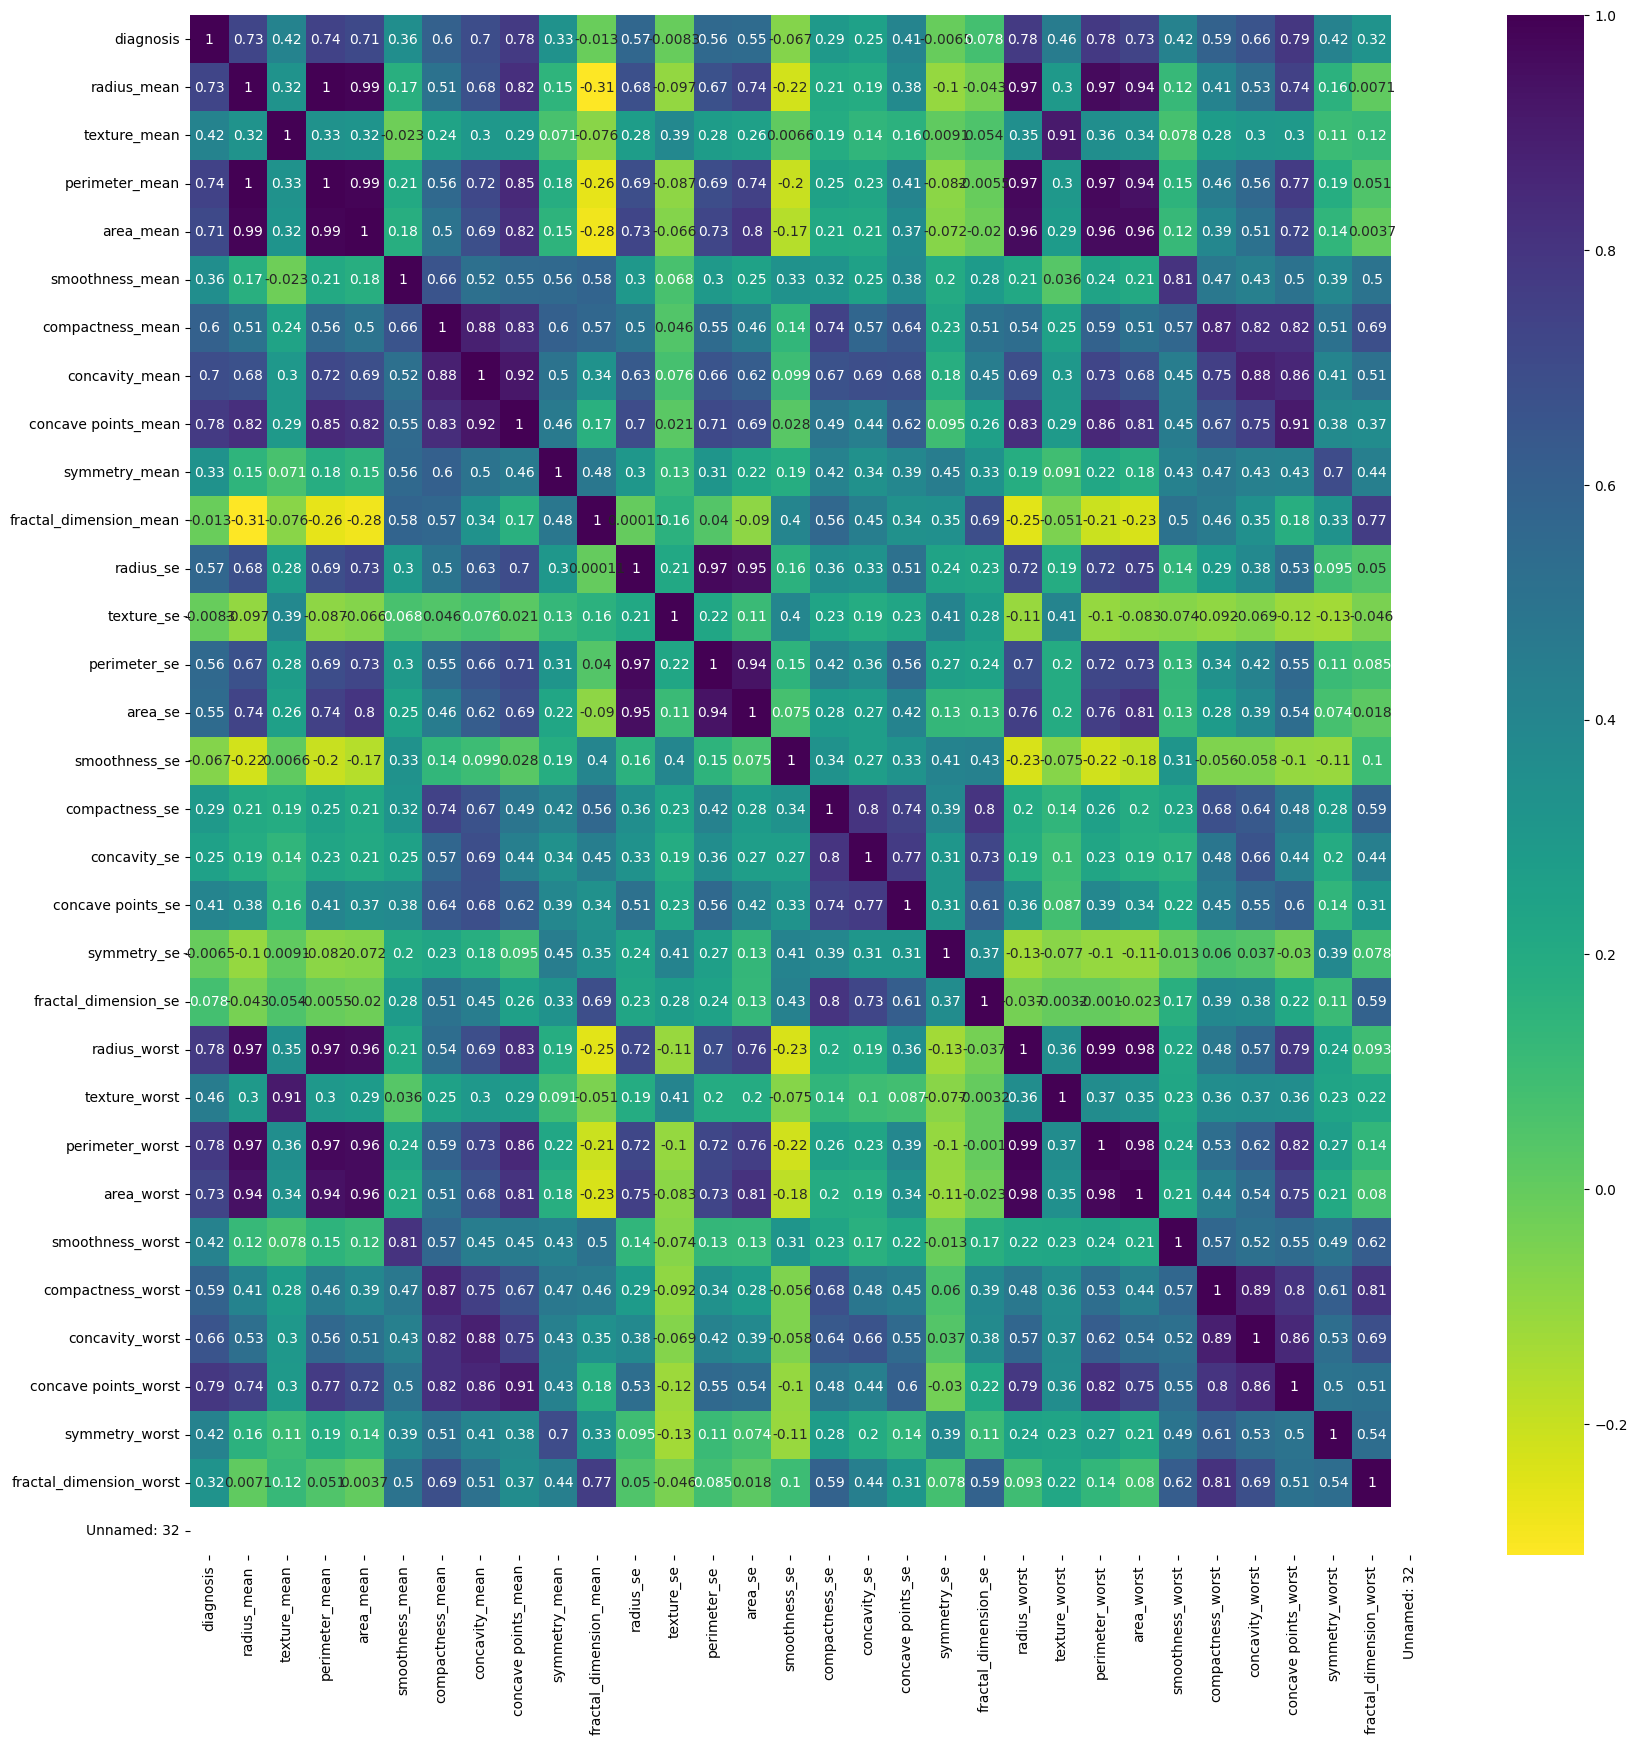

In [11]:
df['diagnosis'] = (df['diagnosis'] == 'M').astype(int) #encode the label into 1/0
corr = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap='viridis_r',annot=True)
plt.show()

In [15]:
# Get the absolute value of the correlation
cor_target = abs(corr["diagnosis"])

# Select highly correlated features (thresold = 0.99)
relevant_features = cor_target[cor_target>0.25]

# Collect the names of the features
names = [index for index, value in relevant_features.items()]

# Drop the target variable from the results
names.remove('diagnosis')
# Display the results
pprint.pprint(names)

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'radius_se',
 'perimeter_se',
 'area_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']


In [16]:
X = df[names].values
y = df['diagnosis'].values.reshape(-1,1)

In [17]:
def scale(X):
    """
    Standardizes the data in the array X.

    Parameters:
        X (numpy.ndarray): Features array of shape (n_samples, n_features).

    Returns:
        numpy.ndarray: The standardized features array.
    """
    # Calculate the mean and standard deviation of each feature
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)

    # Standardize the data
    X = (X - mean) / std

    return X

In [18]:
X = scale(X)

In [42]:
class Node():
    """
    A class representing a node in a decision tree.
    """

    def __init__(self, feature=None, threshold=None, left=None, right=None, gain=None, value=None, num_leaves=0, cost=None, R=None, R_subtree=None):
        """
        Initializes a new instance of the Node class.

        Args:
            feature: The feature used for splitting at this node. Defaults to None.
            threshold: The threshold used for splitting at this node. Defaults to None.
            left: The left child node. Defaults to None.
            right: The right child node. Defaults to None.
            gain: The gain of the split. Defaults to None.
            value: If this node is a leaf node, this attribute represents the predicted value
                for the target variable. Defaults to None.
        """
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.gain = gain
        self.value = value
        
        # Number of leaf nodes in the subtree at this node.
        self.num_leaves = num_leaves
        
        # Effective cost of this node. 
        self.cost = cost
        
        # Risk of the node R(t)
        self.R = R
        # Risk of subtree at this node R(T_t)
        self.R_subtree = R_subtree
    
    def is_leaf(self):
        """
        Returns whether the node is a leaf node or not
        
        Return:
            bool
        """
        return self.left is None and self.right is None

In [99]:
class DecisionTree():
    """
    A decision tree classifier for binary classification problems.
    """

    def __init__(self, min_samples=2, max_depth=2):
        """
        Constructor for DecisionTree class.

        Parameters:
            min_samples (int): Minimum number of samples required to split an internal node.
            max_depth (int): Maximum depth of the decision tree.
        """
        self.min_samples = min_samples
        self.max_depth = max_depth

    def split_data(self, dataset, feature, threshold):
        """
        Splits the given dataset into two datasets based on the given feature and threshold.

        Parameters:
            dataset (ndarray): Input dataset.
            feature (int): Index of the feature to be split on.
            threshold (float): Threshold value to split the feature on.

        Returns:
            left_dataset (ndarray): Subset of the dataset with values less than or equal to the threshold.
            right_dataset (ndarray): Subset of the dataset with values greater than the threshold.
        """
        # Create empty arrays to store the left and right datasets
        left_dataset = []
        right_dataset = []
        
        # Loop over each row in the dataset and split based on the given feature and threshold
        for row in dataset:
            if row[feature] <= threshold:
                left_dataset.append(row)
            else:
                right_dataset.append(row)

        # Convert the left and right datasets to numpy arrays and return
        left_dataset = np.array(left_dataset)
        right_dataset = np.array(right_dataset)
        return left_dataset, right_dataset

    def entropy(self, y):
        """
        Computes the entropy of the given label values.

        Parameters:
            y (ndarray): Input label values.

        Returns:
            entropy (float): Entropy of the given label values.
        """
        entropy = 0

        # Find the unique label values in y and loop over each value
        labels = np.unique(y)
        for label in labels:
            # Find the examples in y that have the current label
            label_examples = y[y == label]
            # Calculate the ratio of the current label in y
            pl = len(label_examples) / len(y)
            # Calculate the entropy using the current label and ratio
            entropy += -pl * np.log2(pl)

        # Return the final entropy value
        return entropy
    
    def gini_index(self, y):
        """
        Calculates the gini index of the given label values.

        Args:
            y (ndarray): Input label values
            
        Returns:
            gini index (float): Gini index of the given label values
        """
        labels = np.unique(y)
        gini = 0
        for label in labels:
            label_examples = y[y == label]
            pl = len(label_examples)/len(y)
            gini += pl ** 2
        return 1 - gini

    def information_gain(self, parent, left, right):
        """
        Computes the information gain from splitting the parent dataset into two datasets.

        Parameters:
            parent (ndarray): Input parent dataset.
            left (ndarray): Subset of the parent dataset after split on a feature.
            right (ndarray): Subset of the parent dataset after split on a feature.

        Returns:
            information_gain (float): Information gain of the split.
        """
        # set initial information gain to 0
        information_gain = 0
        # compute entropy for parent
        parent_entropy = self.entropy(parent)
        # calculate weight for left and right nodes
        weight_left = len(left) / len(parent)
        weight_right= len(right) / len(parent)
        # compute entropy for left and right nodes
        entropy_left, entropy_right = self.entropy(left), self.entropy(right)
        # calculate weighted entropy 
        weighted_entropy = weight_left * entropy_left + weight_right * entropy_right
        # calculate information gain 
        information_gain = parent_entropy - weighted_entropy
        return information_gain
    
    def best_split(self, dataset, num_samples, num_features):
        """
        Finds the best split for the given dataset.

        Args:
        dataset (ndarray): The dataset to split.
        num_samples (int): The number of samples in the dataset.
        num_features (int): The number of features in the dataset.

        Returns:
        dict: A dictionary with the best split feature index, threshold, gain, 
              left and right datasets.
        """
        # dictionary to store the best split values
        best_split = {'gain':- 1, 'feature': None, 'threshold': None}
        # loop over all the features
        for feature_index in range(num_features):
            #get the feature at the current feature_index
            feature_values = dataset[:, feature_index]
            #get unique values of that feature
            thresholds = np.unique(feature_values)
            # loop over all values of the feature
            for threshold in thresholds:
                # get left and right datasets
                left_dataset, right_dataset = self.split_data(dataset, feature_index, threshold)
                # check if either datasets is empty
                if len(left_dataset) and len(right_dataset):
                    # get y values of the parent and left, right nodes
                    y, left_y, right_y = dataset[:, -1], left_dataset[:, -1], right_dataset[:, -1]
                    # compute information gain based on the y values
                    information_gain = self.information_gain(y, left_y, right_y)
                    # update the best split if conditions are met
                    if information_gain > best_split["gain"]:
                        best_split["feature"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["left_dataset"] = left_dataset
                        best_split["right_dataset"] = right_dataset
                        best_split["gain"] = information_gain
        return best_split

    def calculate_leaf_value(self, y):
        """
        Calculates the most occurring value in the given list of y values.

        Args:
            y (list): The list of y values.

        Returns:
            The most occurring value in the list.
        """
        y = list(y)
        #get the highest present class in the array
        most_occuring_value = max(y, key=y.count)
        return most_occuring_value
    
    def build_tree(self, dataset, current_depth=0):
        """
        Recursively builds a decision tree from the given dataset.

        Args:
        dataset (ndarray): The dataset to build the tree from.
        current_depth (int): The current depth of the tree.

        Returns:
        Node: The root node of the built decision tree.
        """
        # split the dataset into X, y values
        X, y = dataset[:, :-1], dataset[:, -1]
        n_samples, n_features = X.shape
        
        # compute leaf node value if it were a leaf node.
        leaf_value = self.calculate_leaf_value(y)
        
        # keeps spliting until stopping conditions are met
        if n_samples >= self.min_samples and current_depth <= self.max_depth:
            # Get the best split
            best_split = self.best_split(dataset, n_samples, n_features)
            # Check if gain isn't zero
            if best_split["gain"]:
                # continue splitting the left and the right child. Increment current depth
                left_node = self.build_tree(best_split["left_dataset"], current_depth + 1)
                right_node = self.build_tree(best_split["right_dataset"], current_depth + 1)
                # return decision node
                return Node(best_split["feature"], best_split["threshold"],
                            left_node, right_node, best_split["gain"],
                            num_leaves=(left_node.num_leaves + right_node.num_leaves),
                            R=self.gini_index(y),
                            value=leaf_value)

        # return leaf node value
        return Node(value=leaf_value, R=self.gini_index(y))
    
    def fit(self, X, y):
        """
        Builds and fits the decision tree to the given X and y values.

        Args:
        X (ndarray): The feature matrix.
        y (ndarray): The target values.
        """
        dataset = np.concatenate((X, y), axis=1)  
        self.root = self.build_tree(dataset)
        self._setup_pruning(self.root)

    def predict(self, X):
        """
        Predicts the class labels for each instance in the feature matrix X.

        Args:
        X (ndarray): The feature matrix to make predictions for.

        Returns:
        list: A list of predicted class labels.
        """
        # Create an empty list to store the predictions
        predictions = []
        # For each instance in X, make a prediction by traversing the tree
        for x in X:
            prediction = self.make_prediction(x, self.root)
            # Append the prediction to the list of predictions
            predictions.append(prediction)
        # Convert the list to a numpy array and return it
        np.array(predictions)
        return predictions
    
    def make_prediction(self, x, node):
        """
        Traverses the decision tree to predict the target value for the given feature vector.

        Args:
        x (ndarray): The feature vector to predict the target value for.
        node (Node): The current node being evaluated.

        Returns:
        The predicted target value for the given feature vector.
        """
        # if the node has value i.e it's a leaf node extract it's value
        if node.is_leaf(): 
            return node.value
        else:
            #if it's node a leaf node we'll get it's feature and traverse through the tree accordingly
            feature = x[node.feature]
            if feature <= node.threshold:
                return self.make_prediction(x, node.left)
            else:
                return self.make_prediction(x, node.right)
    
    def _setup_pruning(self, node):
        if node is None:
            return 0, 0
            
        if node.is_leaf():
            node.num_leaves = 1
            node.R_subtree = 0
            return 1, node.R

        node.num_leaves = node.R_subtree = 0
        
        leaves_left, R_left = self._setup_pruning(node.left)
        leaves_right, R_right = self._setup_pruning(node.right)
        node.num_leaves = leaves_left + leaves_right
        node.R += R_left + R_right
        node.cost = (node.R - node.R_subtree)/(node.num_leaves - 1)
        return node.num_leaves, node.R
    
    def _do_pruning(self, node, alpha):
        if node.is_leaf():
            return
        
        if node.cost < alpha:
            print(f"Node {node} pruned")
            node.left = None
            node.right = None
        else:
            self._do_pruning(node.left, alpha)
            self._do_pruning(node.right, alpha)
    
    def prune(self, alpha):
        """
        Prunes the tree based on the given parameter alpha. 
        Uses cost constrained pruning

        Args:
            alpha (float): Hyper parameter to control cost of leaf nodes as part of cost.
        """
        print(f"Num leaves before pruning: {self.root.num_leaves}")
        self._do_pruning(self.root, alpha)
        self._setup_pruning(self.root)
        print(f"Num leaves after pruning: {self.root.num_leaves}")

In [92]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=41, test_size=0.2)


In [102]:
#create model instance
model = DecisionTree(2, 2)

# Fit the decision tree model to the training data.
model.fit(X_train, y_train)

# Use the trained model to make predictions on the test data.
predictions = model.predict(X_test)

# Calculate evaluating metrics
print(f"Model's Accuracy: {accuracy_score(y_test, predictions)}")
print(f"Model's Balanced Accuracy: {balanced_accuracy_score(y_test, predictions)}")

Model's Accuracy: 0.956140350877193
Model's Balanced Accuracy: 0.960472972972973


In [103]:
# Pruning
model.prune(alpha=0.15)

# Use the trained model to make predictions on the test data.
predictions = model.predict(X_test)

# Calculate evaluating metrics
print(f"Model's Accuracy: {accuracy_score(y_test, predictions)}")
print(f"Model's Balanced Accuracy: {balanced_accuracy_score(y_test, predictions)}")

Num leaves before pruning: 7
Node <__main__.Node object at 0x0000028086EE2830> pruned
Num leaves after pruning: 6
Model's Accuracy: 0.9649122807017544
Model's Balanced Accuracy: 0.9672297297297296


In [28]:
from sklearn.tree import DecisionTreeClassifier

# Create a decision tree classifier model object.
decision_tree_classifier = DecisionTreeClassifier()

# Train the decision tree classifier model using the training data.
decision_tree_classifier.fit(X_train, y_train)

# Use the trained model to make predictions on the test data.
predictions = decision_tree_classifier.predict(X_test)

# Calculate evaluating metrics
print(f" Model's Accuracy: {accuracy_score(y_test, predictions)}")
print(f"Model's Balanced Accuracy: {balanced_accuracy_score(y_test, predictions)}")

 Model's Accuracy: 0.9473684210526315
Model's Balanced Accuracy: 0.9537162162162163


In [31]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

report = classification_report(y_test, predictions)


print(report)

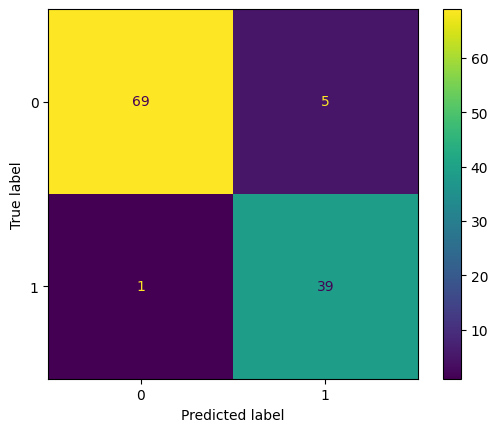

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix = confusion_matrix(y_test, predictions)

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix).plot()
